# NYC taxis tips

In [1]:
import os
_REP_PATH_ = os.getcwd()

## Importation des données

In [2]:
import pandas as pd 

train_df = pd.read_parquet(_REP_PATH_ + '/data/train.parquet')
test_df = pd.read_parquet(_REP_PATH_ + '/data/test.parquet')

# Ajout d'une nouvelle colonne pour spécifier la durée d'un trajet (en minutes)
train_df['trip_duration'] = (train_df["tpep_dropoff_datetime"] - train_df["tpep_pickup_datetime"]).dt.total_seconds()/60 # en minutes
test_df['trip_duration'] = (test_df["tpep_dropoff_datetime"] - test_df["tpep_pickup_datetime"]).dt.total_seconds()/60 # en minutes

# Ajout d'une nouvelle colonne "airport" avec la valeur 0 si la taxe aéroportuaire est = 0 et la valeur 1 sinon 
train_df["airport"] = 1*(train_df["Airport_fee"] > 0)
test_df["airport"] = 1*(test_df["Airport_fee"] > 0)

print(train_df.columns)
train_df.head()


Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
       'Airport_fee', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat',
       'DO_location_lon', 'trip_duration', 'airport'],
      dtype='object')


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,...,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon,trip_duration,airport
0,1,2024-01-15 20:37:28,2024-01-15 20:56:43,1.0,3.30,1.0,N,1,19.1,3.5,...,0.0,1.0,2.5,0.0,40.734576,-74.002875,40.768615,-73.965635,19.250000,0
1,2,2024-01-25 19:41:24,2024-01-25 19:44:42,1.0,0.72,1.0,N,1,5.8,2.5,...,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.780436,-73.957012,3.300000,0
2,2,2024-01-25 15:48:48,2024-01-25 16:24:23,2.0,7.45,1.0,N,1,38.7,0.0,...,0.0,1.0,2.5,0.0,40.717773,-74.007880,40.780436,-73.957012,35.583333,0
3,2,2024-01-27 00:47:26,2024-01-27 00:55:55,1.0,1.53,1.0,N,1,10.0,1.0,...,0.0,1.0,2.5,0.0,40.720889,-73.996919,40.747746,-73.978492,8.483333,0
4,2,2024-01-28 13:14:26,2024-01-28 13:22:34,1.0,1.53,1.0,N,1,10.0,0.0,...,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.747746,-73.978492,8.133333,0


### Correlation

In [3]:
correlation_matrix = train_df.drop(columns= ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag']).corr()

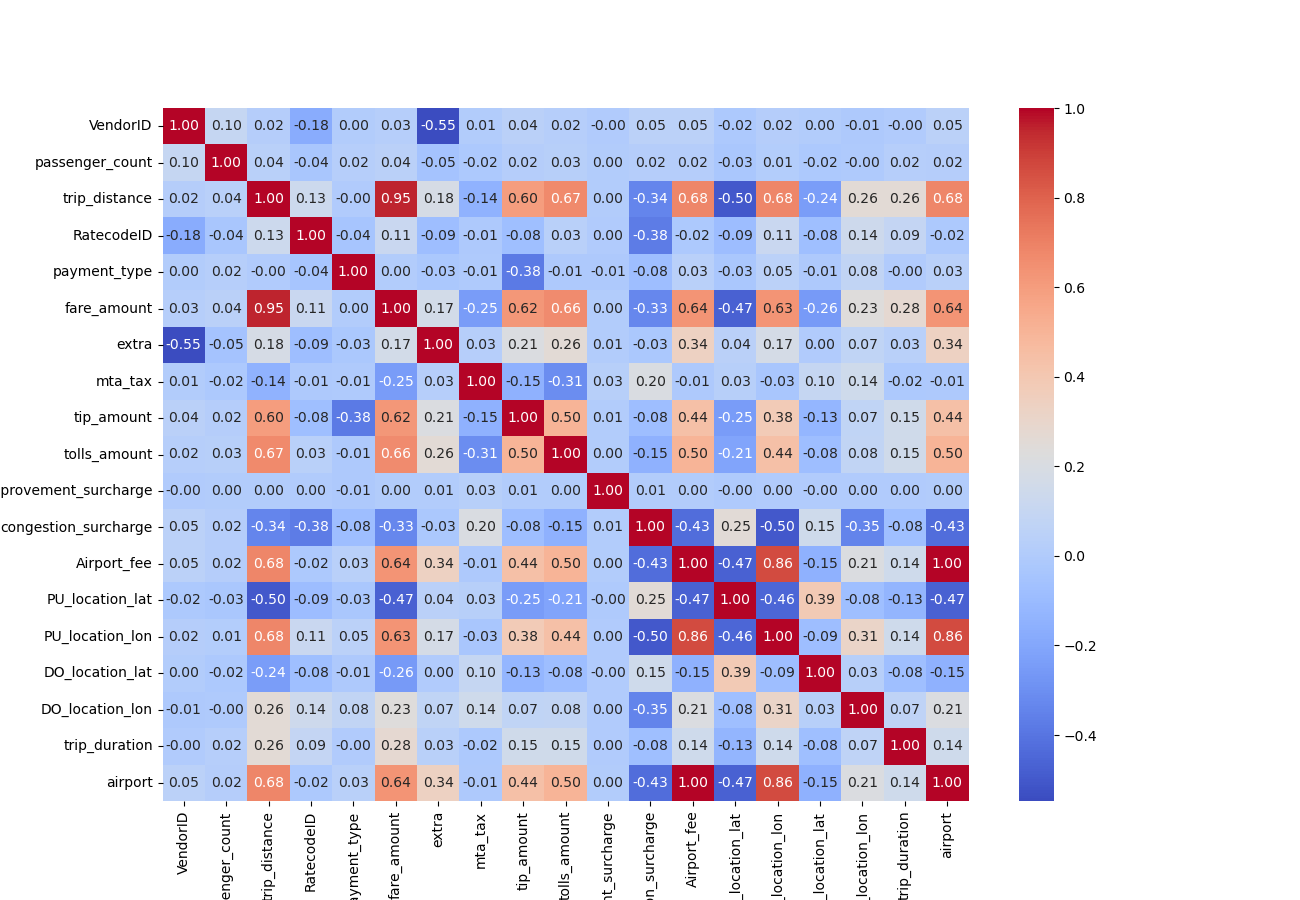

In [4]:
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib ipympl

# Création de la heatmap
plt.figure(figsize=(13,9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Afficher le graphique
plt.show()

### Étude des données en ACP

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np

In [6]:
scaler = StandardScaler()
X_ACP = train_df.drop(columns= ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag'])
X_ACP_standardized = scaler.fit_transform(X_ACP)

In [7]:
mypca = PCA(n_components= 5)

mypca.fit(X_ACP_standardized)

# Pourcentage de la variance expliquée par chacune des composantes sélectionnées.
print(mypca.singular_values_) # Valeurs de variance
print(mypca.explained_variance_ratio_) #  Pourcentages

# Résultats de l'ACP
data_sortie= mypca.fit_transform(X_ACP_standardized)

# Bruit estimé lié à la covariance
print(mypca.noise_variance_)

[753.31529044 406.5846494  400.91678334 371.07337629 340.33723844]
[0.29867575 0.08700583 0.08459698 0.07247129 0.06096286]
0.5378238215435817


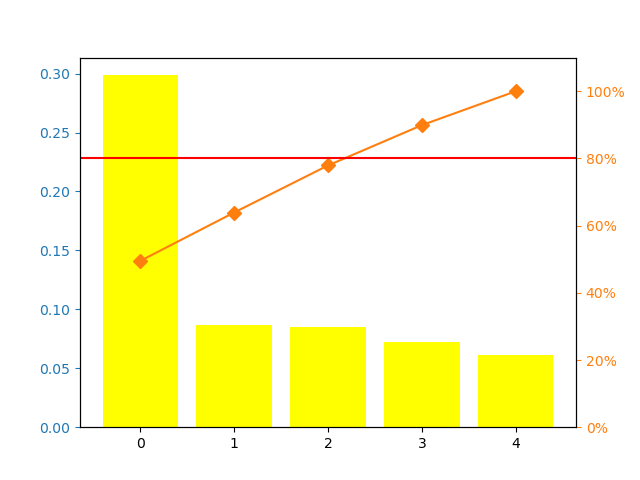

In [8]:
from matplotlib.ticker import PercentFormatter

def pareto(data) :

    y = list(data)
    x = range(len(data))
    
    ycum = np.cumsum(y)/sum(y)*100

    fig, ax = plt.subplots()
    ax.bar(x,y,color="yellow")
    ax2 = ax.twinx()
    ax2.plot(x,ycum, color="C1", marker="D", ms=7)
    ax2.axhline(y=80,color="r")
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax.tick_params(axis="y", colors="C0")
    ax2.tick_params(axis="y", colors="C1")

    plt.ylim(0,110)
    plt.show()

pareto(mypca.explained_variance_ratio_)

$\underline{\textit{Observation :}}$ Un diagramme de pareto permet de s'assurer que les composantes retenues retiendront bien la majorité de la variabilité. Pour qu'un pareto soir pertinaent, il ne fait pas fixer le nombre de composante retenues sinon on ignore volontairement une partie de la variance perdu. Mes 4 premières composantes absorbent bien la majorité de la variabilité. 

In [9]:
loadings = mypca.components_.T * np.sqrt(mypca.explained_variance_)

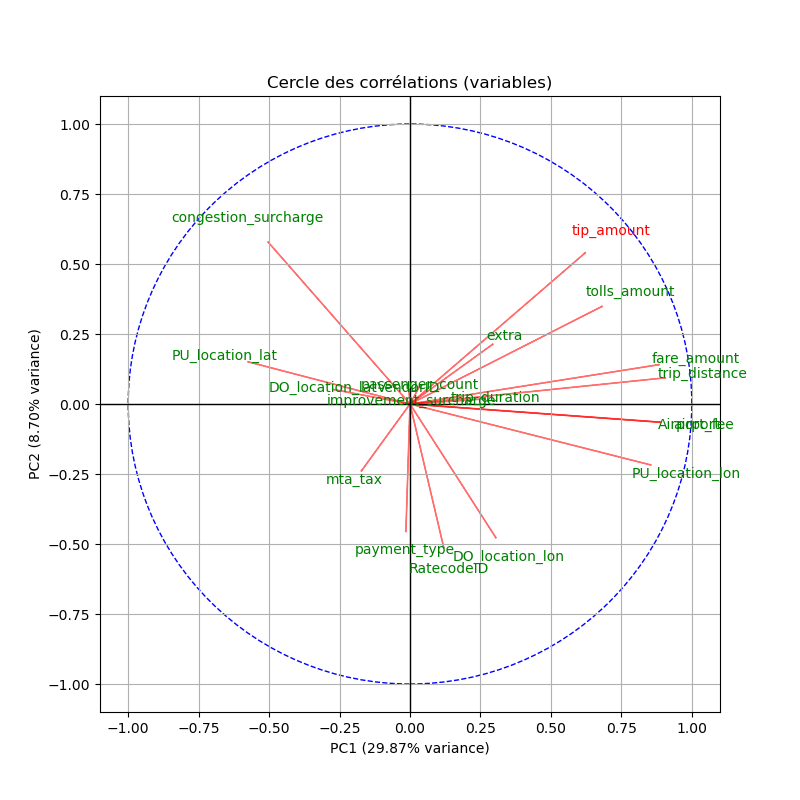

In [10]:
def plot_correlation_circle(loadings, labels, pca, axis):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    axe1, axe2 = axis

    # Définir un cercle de référence pour mieux visualiser
    circle = plt.Circle((0, 0), 1, color='b', fill=False, linestyle='--', linewidth=1)
    ax.add_artist(circle)

    # Tracer les flèches pour chaque variable
    for i in range(len(loadings)):
        plt.arrow(0, 0, loadings[i, axe1], loadings[i, axe2], color='r', alpha=0.5)
        if labels[i] == "tip_amount" :
            plt.text(loadings[i, axe1]*1.15, loadings[i, axe2]*1.15, labels[i], color='red', ha='center', va='center')
        else :
            plt.text(loadings[i, axe1]*1.15, loadings[i, axe2]*1.15, labels[i], color='g', ha='center', va='center')

    # Limites et étiquettes
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel(f"PC{axe1+1} ({pca.explained_variance_ratio_[axe1]*100:.2f}% variance)")
    plt.ylabel(f"PC{axe2+1} ({pca.explained_variance_ratio_[axe2]*100:.2f}% variance)")
    plt.axhline(0, color='black',linewidth=1)
    plt.axvline(0, color='black',linewidth=1)
    plt.grid()
    plt.title('Cercle des corrélations (variables)')
    plt.show()

# Tracer le cercle des variables dans le plan (0,1)
plot_correlation_circle(loadings, labels=X_ACP.columns, pca=mypca, axis = (0,1))


# Modèles de prédiction

## Code Généraux

In [13]:
# fonction d'extraction des données vers un fichier .parquet
_REP_OUT_PATH_ = _REP_PATH_ + '/output/'

def export_to_parquet(filename, Y_pred):
    
    reg_df = pd.DataFrame(np.arange(len(Y_pred), dtype = int).T, columns  = ["row_ID"])
    reg_df["tip_amount"] = Y_pred

    reg_df.to_parquet(_REP_OUT_PATH_ + filename)

In [14]:
# On extrait les variables qui nous intéresse pour créer X, Y
X = train_df.drop(columns= ['tip_amount','tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag']) 

Y = train_df['tip_amount']

X.head()

,VendorID,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon,trip_duration,airport
0,1,1.0,3.30,1.0,1,19.1,3.5,0.5,0.0,1.0,2.5,0.0,40.734576,-74.002875,40.768615,-73.965635,19.250000,0
1,2,1.0,0.72,1.0,1,5.8,2.5,0.5,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.780436,-73.957012,3.300000,0
2,2,2.0,7.45,1.0,1,38.7,0.0,0.5,0.0,1.0,2.5,0.0,40.717773,-74.007880,40.780436,-73.957012,35.583333,0
3,2,1.0,1.53,1.0,1,10.0,1.0,0.5,0.0,1.0,2.5,0.0,40.720889,-73.996919,40.747746,-73.978492,8.483333,0
4,2,1.0,1.53,1.0,1,10.0,0.0,0.5,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.747746,-73.978492,8.133333,0


In [15]:
# Création d'un ensemble de données train/test étiquetée
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.80, random_state=123)

## XGBoost

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

### R2 score : 0.72

In [17]:
# avec toutes les variables, sauf : ['tip_amount','tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag']

XGBoost = GradientBoostingRegressor(random_state= 0,
                                    loss= "squared_error", # Loss function to be optimized. ‘squared_error’ refers to the squared error for regression. ‘absolute_error’ refers to the absolute error of regression and is a robust loss function. ‘huber’ is a combination of the two. ‘quantile’ allows quantile regression
                                    learning_rate=0.1,
                                    n_estimators = 100, # Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
                                    max_depth=3 ) # Maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables. 

In [18]:
XGBoost.fit(X_train, Y_train)
Y_pred = XGBoost.predict(X_test)

print(f"Le score est {XGBoost.score(X_test, Y_test)}")


Le score est 0.7211876182022953


### R2 score : 0.71

In [19]:
# avec toutes les variables, sauf : ['tip_amount','tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag']

XGBoost = GradientBoostingRegressor(random_state= 0,
                                    loss= "squared_error", # Loss function to be optimized. ‘squared_error’ refers to the squared error for regression. ‘absolute_error’ refers to the absolute error of regression and is a robust loss function. ‘huber’ is a combination of the two. ‘quantile’ allows quantile regression
                                    learning_rate=0.3,
                                    n_estimators = 200, # Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
                                    max_depth=5 ) # Maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables. 

XGBoost.fit(X_train, Y_train)
Y_pred = XGBoost.predict(X_test)

print(f"Le score est {XGBoost.score(X_test, Y_test)}")


Le score est 0.6835646263890556


### GridSearch 

In [26]:
from sklearn.model_selection import GridSearchCV

#### Pour le dataFrame complet ; R2 score = 0.72

In [20]:
# 110 mins 

# # Définition du modèle initial
# XGBoost = GradientBoostingRegressor(random_state=0)

# # Définition de la grille des hyperparamètres
# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.3],
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'loss': ['squared_error', 'absolute_error', 'huber']
# }

# # Utilisation de GridSearchCV
# grid_search = GridSearchCV(estimator=XGBoost, param_grid=param_grid, cv=5, scoring='r2', verbose=1)

# # Entraînement du modèle avec GridSearch
# grid_search.fit(X_train, Y_train)

# # Meilleurs paramètres et score associé
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# # Prédictions avec le meilleur modèle trouvé
# Y_pred = grid_search.best_estimator_.predict(X_test)

# # Affichage des résultats
# print(f"Meilleurs paramètres : {best_params}")
# print(f"Meilleur score (validation croisée) : {best_score}")
# print(f"Le score sur le test set est {grid_search.best_estimator_.score(X_test, Y_test)}")


print( "Fitting 5 folds for each of 81 candidates, totalling 405 fits")
print("Meilleurs paramètres : {'learning_rate': 0.01, 'loss': 'huber', 'max_depth': 5, 'n_estimators': 300}")
print("Meilleur score (validation croisée) : 0.7010225519645963")
print("Le score sur le test set est 0.7181374120253667")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Meilleurs paramètres : {'learning_rate': 0.01, 'loss': 'huber', 'max_depth': 5, 'n_estimators': 300}
Meilleur score (validation croisée) : 0.7010225519645963
Le score sur le test set est 0.7181374120253667


#### Pour le Dataframe sans les individus n'ayant pas laissé de tip

In [21]:
# Création d'un nouveau jeu de données sans prendre en compte les personnes n'ayant pas donné de tips

new_train_df = train_df[train_df["tip_amount"]>0]

X_new = new_train_df.drop(columns= ['tip_amount','tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag']) 
Y_new = new_train_df['tip_amount']

# Nouveau jeu de données train/test
X_train_new, X_test_new, Y_train_new, Y_test_new = train_test_split(X_new, Y_new, train_size = 0.80, random_state=123)

In [22]:
XGBoost = GradientBoostingRegressor(random_state= 0,
                                    loss= "squared_error", # Loss function to be optimized. ‘squared_error’ refers to the squared error for regression. ‘absolute_error’ refers to the absolute error of regression and is a robust loss function. ‘huber’ is a combination of the two. ‘quantile’ allows quantile regression
                                    learning_rate=0.1,
                                    n_estimators = 100, # Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
                                    max_depth=3 ) # Maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables. 

XGBoost.fit(X_train_new, Y_train_new)
Y_pred = XGBoost.predict(X_test_new)

print(f"Le score est {XGBoost.score(X_test_new, Y_test_new)}")

Le score est 0.7210644526809933


In [23]:
# 30 mins

# # Définition du modèle initial
# XGBoost = GradientBoostingRegressor(random_state=0)

# # Définition de la grille des hyperparamètres
# param_grid = {
#     'learning_rate': [0.1, 0.15],
#     'n_estimators': [1000],
#     'max_depth': [3, 4],
#     'loss': ['squared_error']
# }

# # Utilisation de GridSearchCV
# grid_search = GridSearchCV(estimator=XGBoost, param_grid=param_grid, cv=5, scoring='r2', verbose=1)

# # Entraînement du modèle avec GridSearch
# grid_search.fit(X_train_new, Y_train_new)

# # Meilleurs paramètres et score associé
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# # Prédictions avec le meilleur modèle trouvé
# Y_pred = grid_search.best_estimator_.predict(X_test_new)

# # Affichage des résultats
# print(f"Meilleurs paramètres : {best_params}")
# print(f"Meilleur score (validation croisée) : {best_score}")
# print(f"Le score sur le test set est {grid_search.best_estimator_.score(X_test_new, Y_test_new)}")

print("Fitting 5 folds for each of 4 candidates, totalling 20 fits")
print("Meilleurs paramètres : {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'n_estimators': 1000}")
print("Meilleur score (validation croisée) : 0.6920254171253702")
print("Le score sur le test set est 0.7059400244334677")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs paramètres : {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'n_estimators': 1000}
Meilleur score (validation croisée) : 0.6920254171253702
Le score sur le test set est 0.7059400244334677


## Régression Linéaire

In [18]:
from sklearn.linear_model import LinearRegression

### R2 score :0.5450

In [19]:
# On utilise les variables : congestion_surcharge, airport, PU_location_lon, DO_location_lon, RatecodeID, payment_type, trip_distance, PU_location_lat

columns = ["congestion_surcharge", "airport", "PU_location_lon", "DO_location_lon", "RatecodeID", "payment_type", "trip_distance", "PU_location_lat"]
X_train_, X_test_ = X_train[columns], X_test[columns]

reg = LinearRegression().fit(X_train_, Y_train)

Y_pred = reg.predict(X_test_)

print(f"Le Score r2 est {r2_score(Y_test, Y_pred)}")

Le Score r2 est 0.5450440156599741


### R2 score : 0.57509

In [21]:
X_train_ = X_train.drop(columns = ["passenger_count", "mta_tax", "RatecodeID", "improvement_surcharge", "tolls_amount"])
X_test_ = X_test.drop(columns = ["passenger_count", "mta_tax", "RatecodeID", "improvement_surcharge", "tolls_amount"])

reg = LinearRegression().fit(X_train_, Y_train)

Y_pred = reg.predict(X_test_)

print(f"Le Score r2 est {r2_score(Y_test, Y_pred)}")

# export_to_parquet("linear_regression_1.parquet", Y_pred = Y_pred)

Le Score r2 est 0.5789703556526412


### R2 score : 0.57509

In [22]:
reg = LinearRegression().fit(X_train, Y_train)

Y_pred = reg.predict(X_test)

export_to_parquet("linear_regression_2.parquet", Y_pred = Y_pred)

### R2 score : 0.35943

In [23]:
X_train_ = X_train[["passenger_count", "trip_distance"]]
X_test_ = X_test[["passenger_count", "trip_distance"]]

reg = LinearRegression().fit(X_train_, Y_train)

Y_pred = reg.predict(X_test_)

export_to_parquet("prediction_1.parquet", Y_pred= Y_pred)